<p> This notebook compares the magnitude response and interchannel coherence of 3 types of stereo decorrelation filters -allpass cascade, velvet noise and optimised velvet noise
</p>

In [16]:
import numpy as np
from scipy.fft import rfft, rfftfreq
from scipy.signal import sosfreqz
from importlib import reload
import matplotlib.pyplot as plt
import os, sys
from tqdm import tqdm
from scipy.io import loadmat, savemat
from typing import Optional
path = os.path.abspath('../.')
sys.path.append(path)

In [9]:
from velvet import *
from allpass import *
from utils import ms_to_samps, db
from plot import *
from utils import calculate_interchannel_cross_correlation_matrix

### Helper functions

In [19]:
def get_ir_spectrum(ir:np.ndarray, fs: float):
    num_chan, ir_len = ir.shape
    fft_size = np.int32(2 ** np.ceil(np.log2(ir_len)))
    ir_spectrum = rfft(ir, fft_size, axis=-1)
    freq_axis = rfftfreq(fft_size, d = 1.0/fs)
    return ir_spectrum, freq_axis


def plot_sos_response(sos:np.ndarray, fs: float, num_bins:int):
    if sos.ndim == 3:
        num_chan = sos.shape[0]
        freq_response = np.zeros((num_chan, num_bins), dtype = complex)
        for chan in range(num_chan):
            w, freq_response[chan, :] = sosfreqz(sos[chan, ...], worN=num_bins)
    else:
        w, freq_response = sosfreqz(sos, worN=num_bins)
    freqs = w / np.pi * fs
    return freq_response, freqs


def pick_minimum_coherence_decorrelator(decorr_irs :float, 
                                        fs: float, 
                                        num_iters : int, 
                                        num_channels: int = 2, 
                                        bands_per_octave :int = 3,
                                        cost_fn_vals: Optional[np.ndarray] = None) -> int:
    iac_freqs = pf.dsp.filter.fractional_octave_frequencies(num_fractions=bands_per_octave, 
                                            frequency_range=(20, sample_rate/2.0), 
                                            return_cutoff=False)[0]
    num_freqs = len(iac_freqs)
    icc_matrix_all = np.zeros((num_iters, num_freqs))
    for num_ir in tqdm(range(num_iters)):
        icc_matrix, _ = calculate_interchannel_cross_correlation_matrix(np.squeeze(decorr_irs[num_ir, ...]),
                                                                        fs=fs,
                                                                        num_channels=num_channels,
                                                                        time_axis=-1,
                                                                        channel_axis=0,
                                                                        bands_per_octave=bands_per_octave,
                                                                        freq_range=(20, fs/2.0))

        icc_matrix_all[num_ir, :] = np.squeeze(icc_matrix[..., 0, 1])

    # weighted cost function taking into account min ICC and spectral flatness
    mean_icc = np.mean(np.abs(icc_matrix_all), axis=-1)
    if cost_fn_vals is None:
        return np.argmin(mean_icc)
    else:
        lamb = 0.5
        meu = 0.1
        net_cost_function = (1-lamb) * mean_icc + lamb * meu * np.sum(cost_fn_vals, axis=-1)
        return np.argmin(net_cost_function)

### Global parameters

In [11]:
sample_rate = 48000
ir_length_ms = 15
ir_length_samps = ms_to_samps(ir_length_ms, sample_rate)
num_biquads = 200
num_channels = 2
num_iter = 100
save_flag = True
plot_flag = True if num_iter == 1 else False

### Loop over stereo channels

In [12]:
ap_ir = np.zeros((num_iter, num_channels, ir_length_samps))
sos_section = np.zeros((num_iter, num_channels, num_biquads, 6))
init_vn_sequence = np.zeros_like(ap_ir)
opt_vn_sequence = np.zeros_like(ap_ir)
cost_fn_val = np.zeros((num_iter, num_channels))

#### Create allpass biquad sequence

In [13]:
for iter in tqdm(range(num_iter)):
    for chan in range(num_channels):
        sos_section[iter, chan, ...] = decorrelate_allpass_filters(sample_rate, nbiquads = num_biquads, max_grp_del_ms = 30)
        ap_ir[iter, chan, :] = get_allpass_impulse_response(sos_section[iter, chan, ...], sample_rate, ir_length_ms)
        if plot_flag:
            fig = plt.figure()
            plt.subplot(111)
            plt.plot(ap_ir[chan, :])
            plt.title('Allpass IR')

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 511.81it/s]


#### Create a VN sequence and optimise it iif the optimised files don't exist already

In [14]:
loadpath = "../../../Resources/decorrelation_ir_matrix.mat"
try:
    ir_dict = loadmat(loadpath)
    init_vn_sequence = ir_dict['velvet']
    opt_vn_sequence = ir_dict['opt-velvet']
    cost_fn_val = ir_dict['cost_func-vals']
except: 
    raise OSError("File not found")
    
    for iter in tqdm(range(num_iter)):
        for chan in range(num_channels):
            # number of VN sequences
            num_seq = 1
            # 1 samples per millisecond
            num_samp_per_ms = 1
            grid_size = int(sample_rate / (num_samp_per_ms*1e3))
            ir_length_samps = ms_to_samps(ir_length_ms, sample_rate)
            decay_db = 60
        
            init_vn_seq = np.squeeze(generate_velvet_noise_sequence(num_seq, sample_rate, grid_size, ir_length_samps).T)
            impulse_locations = np.nonzero(init_vn_seq)[0]
            impulse_signs = np.sign(init_vn_seq[impulse_locations])
            num_impulses = len(impulse_locations)
        
            decay_slope = -np.log(np.power(10, -decay_db / 20)) / ir_length_samps
            init_vn_seq_with_decay = np.zeros_like(init_vn_seq)
            init_vn_seq_with_decay[impulse_locations] = np.exp(-impulse_locations * decay_slope) * impulse_signs
        
        
            #### Optimise the VN sequence
        
            num_samples_per_second = sample_rate / grid_size
            opt_vn_seq, opt_vn_params, cost_fn_val[iter, chan] = optimise_velvet_noise_sequence(init_vn_seq, 
                                                        sample_rate, 
                                                        num_samples_per_second, 
                                                        impulse_locations, 
                                                        decay_db,
                                                        verbose=False)
        
            init_vn_sequence[iter, chan, :] = init_vn_seq_with_decay
            opt_vn_sequence[iter, chan, :] = opt_vn_seq
        
            #### Plot the original and optimised sequence
            if plot_flag:
                fig = plt.figure()
                plt.subplot(211)
                plt.stem(init_vn_sequence[chan, :])
                plt.ylim([-1, 1])
                plt.title('VN sequence')
            
                plt.subplot(212)
                plt.stem(opt_vn_sequence[chan, :])
                plt.title('Optimised VN sequence')
                plt.ylim([-1, 1])
        if plot_flag:
            fig.tight_layout(pad=1.0)


  0%|                                                   | 0/100 [00:00<?, ?it/s]2024-02-05 14:21:11.610 | DEBUG    | velvet:optimise_velvet_noise_sequence:356 - Optimisation was successful True
/Users/orchisamadas/Documents/AudioApps/StereoWidener/Python/.venv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
2024-02-05 14:21:35.249 | DEBUG    | velvet:optimise_velvet_noise_sequence:356 - Optimisation was successful True
  1%|▍                                        | 1/100 [00:52<1:27:25, 52.98s/it]2024-02-05 14:22:00.923 | DEBUG    | velvet:optimise_velvet_noise_sequence:356 - Optimisation was successful True
2024-02-05 14:22:13.352 | DEBUG    | velvet:optimise_velvet_noise_sequence:356 - Optimisation was successful True
  2%|▊                                        | 2/100 [01:31<1:12:14, 44.23s/it]2024-02-05 14:22:21.860 |

### For each decorrelator, find the IR pair that gives the minimum IC over all frequency bands

In [20]:
all_irs = np.stack((ap_ir, init_vn_sequence, opt_vn_sequence), axis = -1)
num_irs = np.shape(all_irs)[-1]
min_ir_idx = dict()
keys = ['allpass' ,'velvet' ,'opt-velvet']
for k in range(num_irs):
    if keys[k] == 'opt-velvet':
        min_ir_idx[keys[k]] = pick_minimum_coherence_decorrelator(all_irs[...,-1], sample_rate, num_iter, cost_fn_vals=cost_fn_val)
    else:     
        min_ir_idx[keys[k]] = pick_minimum_coherence_decorrelator(all_irs[...,-1], sample_rate, num_iter)
    

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.63it/s]


### Save VN and optimised VN sequence that gives minimum IC

In [21]:
if save_flag:
    with open('../../../Resources/opt_vn_filters.txt','wb') as f:
        np.savetxt(f, np.squeeze(opt_vn_sequence[min_ir_idx['opt-velvet']]), fmt='%.4f')
    
    with open('../../../Resources/init_vn_filters.txt','wb') as f:
        np.savetxt(f, np.squeeze(init_vn_sequence[min_ir_idx['velvet']]), fmt='%.4f')

### Compare the magnitude spectrum of all 3

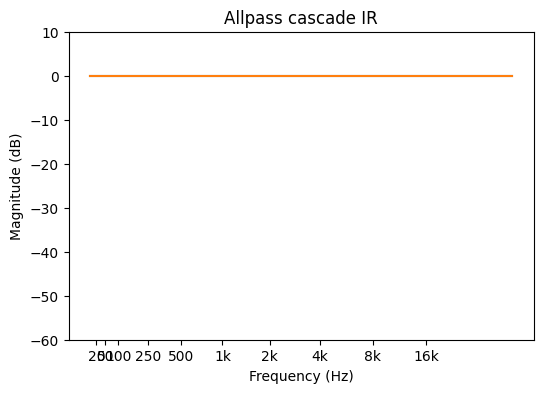

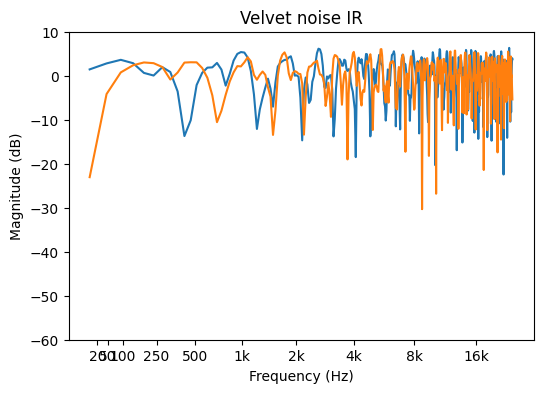

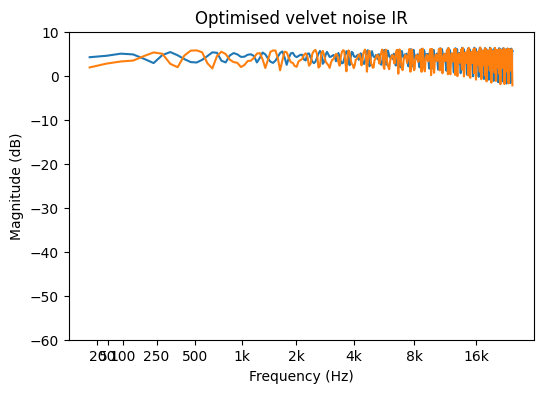

In [22]:
impulse_mag, freq_axis = plot_sos_response(sos_section[min_ir_idx['allpass']], 
                                           sample_rate, 
                                           num_bins = np.int32(2 ** np.ceil(np.log2(ir_length_samps))))
plt.figure(figsize=[6, 4])
semiaudplot(freq_axis, db(np.abs(impulse_mag)))
plt.title('Allpass cascade IR')
plt.ylabel('Magnitude (dB)')
plt.ylim([-60, 10])
if save_flag:
    plt.savefig('../../figures/ap_mag_response.png', dpi=300)


impulse_mag, freq_axis = get_ir_spectrum(init_vn_sequence[min_ir_idx['velvet']], sample_rate)
plt.figure(figsize=[6, 4])
semiaudplot(freq_axis, db(np.abs(impulse_mag)))
plt.title('Velvet noise IR')
plt.ylim([-60, 10])
plt.ylabel('Magnitude (dB)')
if save_flag:
    plt.savefig('../../figures/velvet_mag_response.png', dpi=300)


impulse_mag, freq_axis = get_ir_spectrum(opt_vn_sequence[min_ir_idx['opt-velvet']], sample_rate)
plt.figure(figsize=[6, 4])
semiaudplot(freq_axis, db(np.abs(impulse_mag)))
plt.title('Optimised velvet noise IR')
plt.ylim([-60, 10])
plt.ylabel('Magnitude (dB)')
if save_flag:
    plt.savefig('../../figures/opt_velvet_response.png', dpi=300)



### Compare the interchannel coherence of all 3

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.19it/s]


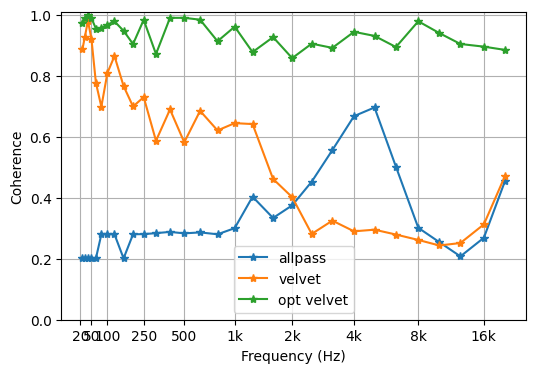

In [23]:
import pyfar as pf

bands_per_octave=3
iac_freqs = pf.dsp.filter.fractional_octave_frequencies(num_fractions=bands_per_octave, 
                                            frequency_range=(20, sample_rate/2.0), 
                                            return_cutoff=False)[0]
num_freqs = len(iac_freqs)
icc_vector_all = np.zeros((num_iter, num_freqs, num_irs))
fig, axis = plt.subplots(figsize=(6, 4))
titles = ['Allpass', 'Velvet', 'Optimised Velvet']

for iter in tqdm(range(num_iter)):
    for num_ir in range(num_irs):
        icc_matrix, _ = calculate_interchannel_cross_correlation_matrix(all_irs[iter, ..., num_ir],
                                                                        fs=sample_rate,
                                                                        num_channels=num_channels,
                                                                        time_axis=-1,
                                                                        channel_axis=0,
                                                                        bands_per_octave=bands_per_octave,
                                                                        freq_range=(20, sample_rate/2.0))
        icc_vector_all[iter,:, num_ir] = np.squeeze(icc_matrix[..., 0, 1])

    
semiaudplot(iac_freqs, np.median(icc_vector_all, axis=0), marker='*', interp=False)
plt.ylabel('Coherence')
plt.ylim([0, 1.01])
plt.legend(['allpass', 'velvet', 'opt velvet'])
plt.grid()
if save_flag:
    plt.savefig('../../figures/decorr_iac.png', dpi=300)


In [24]:
ir_dict= {"allpass": ap_ir, "velvet":init_vn_sequence, "opt-velvet":opt_vn_sequence, "cost-func-vals" : cost_fn_val}
savemat("../../../Resources/decorrelation_ir_matrix.mat", ir_dict)